In [1]:
import os
import sys
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import random

parentPath = os.path.abspath("../..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)

import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = parentPath

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

SCENENN_DIR = "/external_datasets/SceneNet_RGBD"

Using TensorFlow backend.


In [2]:
# import SceneNet
from dataset import *

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Validation dataset
dataset_test = ObjectsDataset()
dataset_test.load_sceneNet(SCENENN_DIR, "validation", skip=199)
dataset_test.prepare()

Loading validation data from 0, 170
Loading validation data from 0, 224
Loading validation data from 0, 766
Loading validation data from 0, 728
Loading validation data from 0, 54
Loading validation data from 0, 559
Loading validation data from 0, 144
Loading validation data from 0, 746
Loading validation data from 0, 148
Loading validation data from 0, 198
Loading validation data from 0, 381
Loading validation data from 0, 674
Loading validation data from 0, 91
Loading validation data from 0, 570
Loading validation data from 0, 234
Loading validation data from 0, 825
Loading validation data from 0, 169
Loading validation data from 0, 740
Loading validation data from 0, 692
Loading validation data from 0, 983
Loading validation data from 0, 108
Loading validation data from 0, 257
Loading validation data from 0, 129
Loading validation data from 0, 836
Loading validation data from 0, 261
Loading validation data from 0, 105
Loading validation data from 0, 448
Loading validation data from 0

Loading validation data from 0, 187
Loading validation data from 0, 337
Loading validation data from 0, 176
Loading validation data from 0, 334
Loading validation data from 0, 627
Loading validation data from 0, 842
Loading validation data from 0, 316
Loading validation data from 0, 640
Loading validation data from 0, 562
Loading validation data from 0, 834
Loading validation data from 0, 319
Loading validation data from 0, 36
Loading validation data from 0, 661
Loading validation data from 0, 349
Loading validation data from 0, 260
Loading validation data from 0, 819
Loading validation data from 0, 441
Loading validation data from 0, 329
Loading validation data from 0, 103
Loading validation data from 0, 884
Loading validation data from 0, 946
Loading validation data from 0, 999
Loading validation data from 0, 954
Loading validation data from 0, 831
Loading validation data from 0, 737
Loading validation data from 0, 76
Loading validation data from 0, 970
Loading validation data from 0

Loading validation data from 0, 739
Loading validation data from 0, 98
Loading validation data from 0, 243
Loading validation data from 0, 816
Loading validation data from 0, 331
Loading validation data from 0, 803
Loading validation data from 0, 617
Loading validation data from 0, 698
Loading validation data from 0, 55
Loading validation data from 0, 398
Loading validation data from 0, 14
Loading validation data from 0, 722
Loading validation data from 0, 348
Loading validation data from 0, 53
Loading validation data from 0, 388
Loading validation data from 0, 686
Loading validation data from 0, 496
Loading validation data from 0, 464
Loading validation data from 0, 21
Loading validation data from 0, 724
Loading validation data from 0, 732
Loading validation data from 0, 52
Loading validation data from 0, 626
Loading validation data from 0, 580
Loading validation data from 0, 544
Loading validation data from 0, 567
Loading validation data from 0, 869
Loading validation data from 0, 24

Loading validation data from 0, 733
Loading validation data from 0, 731
Loading validation data from 0, 288
Loading validation data from 0, 493
Loading validation data from 0, 113
Loading validation data from 0, 444
Loading validation data from 0, 566
Loading validation data from 0, 455
Loading validation data from 0, 832
Loading validation data from 0, 17
Loading validation data from 0, 286
Loading validation data from 0, 90
Loading validation data from 0, 320
Loading validation data from 0, 44
Loading validation data from 0, 84
Loading validation data from 0, 139
Loading validation data from 0, 434
Loading validation data from 0, 651
Loading validation data from 0, 526
Loading validation data from 0, 328
Loading validation data from 0, 764
Loading validation data from 0, 343
Loading validation data from 0, 358
Loading validation data from 0, 710
Loading validation data from 0, 588
Loading validation data from 0, 957
Loading validation data from 0, 222
Loading validation data from 0, 

Loading validation data from 0, 973
Loading validation data from 0, 262
Loading validation data from 0, 438
Loading validation data from 0, 653
Loading validation data from 0, 683
Loading validation data from 0, 760
Loading validation data from 0, 146
Loading validation data from 0, 508
Loading validation data from 0, 359
Loading validation data from 0, 10
Loading validation data from 0, 114
Loading validation data from 0, 616
Loading validation data from 0, 811
Loading validation data from 0, 802
Loading validation data from 0, 907
Loading validation data from 0, 409
Loading validation data from 0, 663
Loading validation data from 0, 844
Loading validation data from 0, 297
Loading validation data from 0, 418
Loading validation data from 0, 718
Loading validation data from 0, 934
Loading validation data from 0, 899
Loading validation data from 0, 71
Loading validation data from 0, 419
Loading validation data from 0, 218
Loading validation data from 0, 591
Loading validation data from 0

## Detection

In [5]:
class InferenceConfig(ObjectsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

/external_datasets/SceneNet_RGBD/validation/0/605/photo/375.jpg
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000
depth                    shape: (320, 320)            min:    0.00000  max: 2901.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1513.00000
bbox                     shape: (6, 4)                min:    0.00000  max:  320.00000
mask                     shape: (320, 320, 6)         min:    0.00000  max:    1.00000


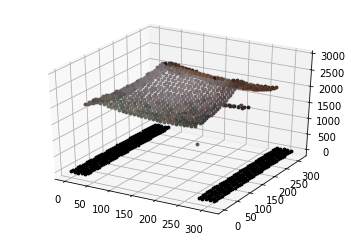

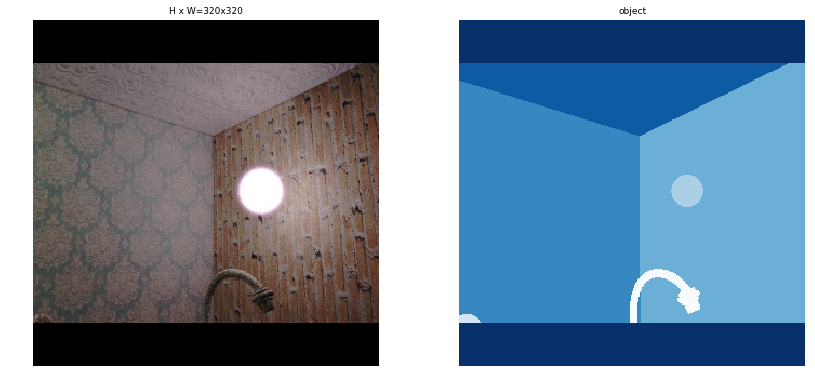

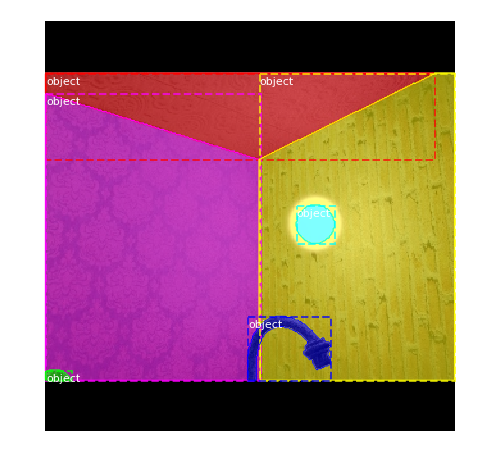

In [28]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, class_ids, bbox, mask=\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_test.image_info[image_id]['path'])
image = original_image[:, :, 0:3]
depth = original_image[:, :, 3]
log("image", image)
log("depth", depth)
log("image_meta", image_meta)
log("bbox", bbox)
log("mask", mask)
if 1:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    skip = 8
    for x in range(image.shape[0]):
        if x % skip == 0:
            for y in range(image.shape[1]):
                if y % skip == 0:
#                     print(image[x, y] / 255.0)
                    ax.scatter(
                        x, y, depth[x, y],
                        c=image[x, y] / 255.0, s=8)
    plt.show()

visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names, limit=1)

visualize.display_instances(image, bbox, mask, class_ids, dataset_test.class_names, figsize=(8, 8))

0.07673800000000597


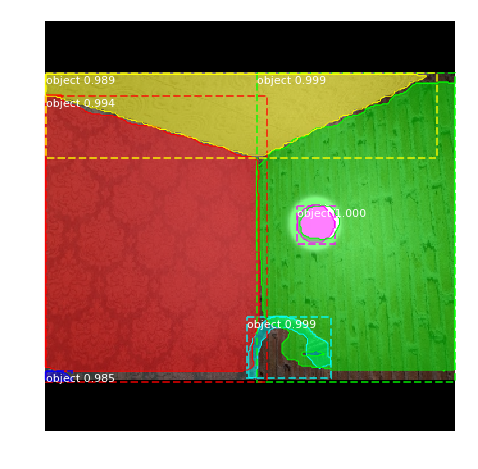

In [29]:
# model_paths = model.find_all()
# for model_path in model_paths:
#     print("Loading weights from ", model_path[0])
#     for checkpoint in model_path[1]:
#         print("    " + checkpoint)
        # model.load_weights(checkpoint, by_name=True)
model.load_weights(model.find_last()[1], by_name=True)
start = time.clock()
r = model.detect([original_image])[0]
print(time.clock() - start)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                    dataset_test.class_names, r['scores'], ax=get_ax())

## Evaluation

In [8]:
%%script false
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 20)
APs = []
for i, image_id in enumerate(image_ids):
    # Load image and ground truth data
    image_path = dataset_test.image_info[image_id]['path']
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask  =\
            modellib.load_image_gt(dataset_test, inference_config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, r["rois"], r["class_ids"], r["scores"])
        APs.append(AP)
        print('{}: {}: {}'.format(i + 1, image_path, AP))
    except:
        print("Error processing image {}".format(image_path))

print("mAP: ", np.mean(APs))